In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from functools import partial
from time import time
from objective_functions import arctan_loss
from utils import compute_crossing_percentage, scoring_loss, plot_quantiles, pinball_loss_total
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# 1. Data simulation

In [3]:
np.random.seed(2)
X = np.random.uniform(0, 1, (1000,1))
X_test = np.random.uniform(0, 1, (10000,1))
Y = (np.random.normal(loc=0.5*np.sin(7*X), scale=0.2))
Y_test = np.random.normal(loc=0.5*np.sin(7*X_test), scale=0.2)

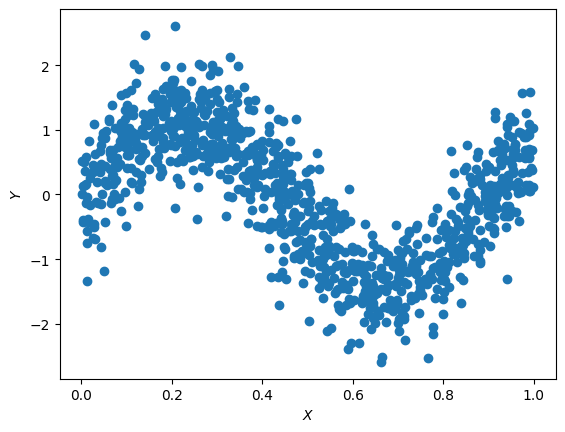

In [4]:
plt.scatter(X, (Y - np.mean(Y)) / np.std(Y))
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

In [5]:
K = 10
taus = [np.round(-0.05 + i * 1 / (K),2) for i in range(K, 0, -1)]
targets = np.zeros((len(Y), K))
for i in range(K):
    targets[:, i] = Y[:, 0]

# 2. Comparing original approach and new approach

### 2.1 Pipeline and gridsearch

3 fold cross validation is used to determine the best hyperparameters for both approaches. The eventual model is fit on the entire training set using the optimal hyperparameters. The targets and inputs are standardized prior to training.

In [6]:
xgb_new = xgb.XGBRegressor(objective=partial(arctan_loss, taus=taus, s=0.05),
                           base_score=0,
                           multi_strategy="multi_output_tree",
                           min_child_weight=0,
                           max_delta_step=.5)

xgb_original = xgb.XGBRegressor(objective='reg:quantileerror', quantile_alpha=taus, base_score=0,
                                min_child_weight=0)

def get_best_model(model, X, Y, param_grid):
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=StandardScaler())
    grid_search = GridSearchCV(wrapped_model, param_grid, cv=3,
                           scoring=partial(scoring_loss, taus=taus))
    grid_search.fit(X, Y)
    return grid_search

param_grid = {
            'regressor__n_estimators': [100, 200, 400],
            'regressor__max_leaves': [400],
            'regressor__max_depth': [2, 3, 4],
            'regressor__learning_rate': [0.05],
            'regressor__gamma': [0.1, 0.25, 0.5, 1, 2.5, 5, 10],
            'regressor__lambda': [0.01, 0.1, 0.25, 0.5, 1, 2.5, 5, 10],
        }
start_time2 = time()
grid_search_new = get_best_model(xgb_new, X, targets, param_grid)
end_time2 = time()

In [7]:
start_time1 = time()
grid_search_original = get_best_model(xgb_original, X, Y, param_grid)
end_time1 = time()

In [8]:
print(f"Original approach took {end_time1 - start_time1:.2f} seconds to fit.")
print(f"New approach took {end_time2 - start_time2:.2f} seconds to fit.")

Original approach took 4413.89 seconds to fit.
New approach took 2149.49 seconds to fit.


In [9]:
x_values = np.linspace(-0, 1, 3000).reshape((3000, 1))
y_values = np.random.normal(loc=0.5*np.sin(7*x_values), scale=0.2)
new_quantiles = grid_search_new.best_estimator_.predict(x_values)
original_quantiles = grid_search_original.best_estimator_.predict(x_values)

 ### 2.2 Visualize the results

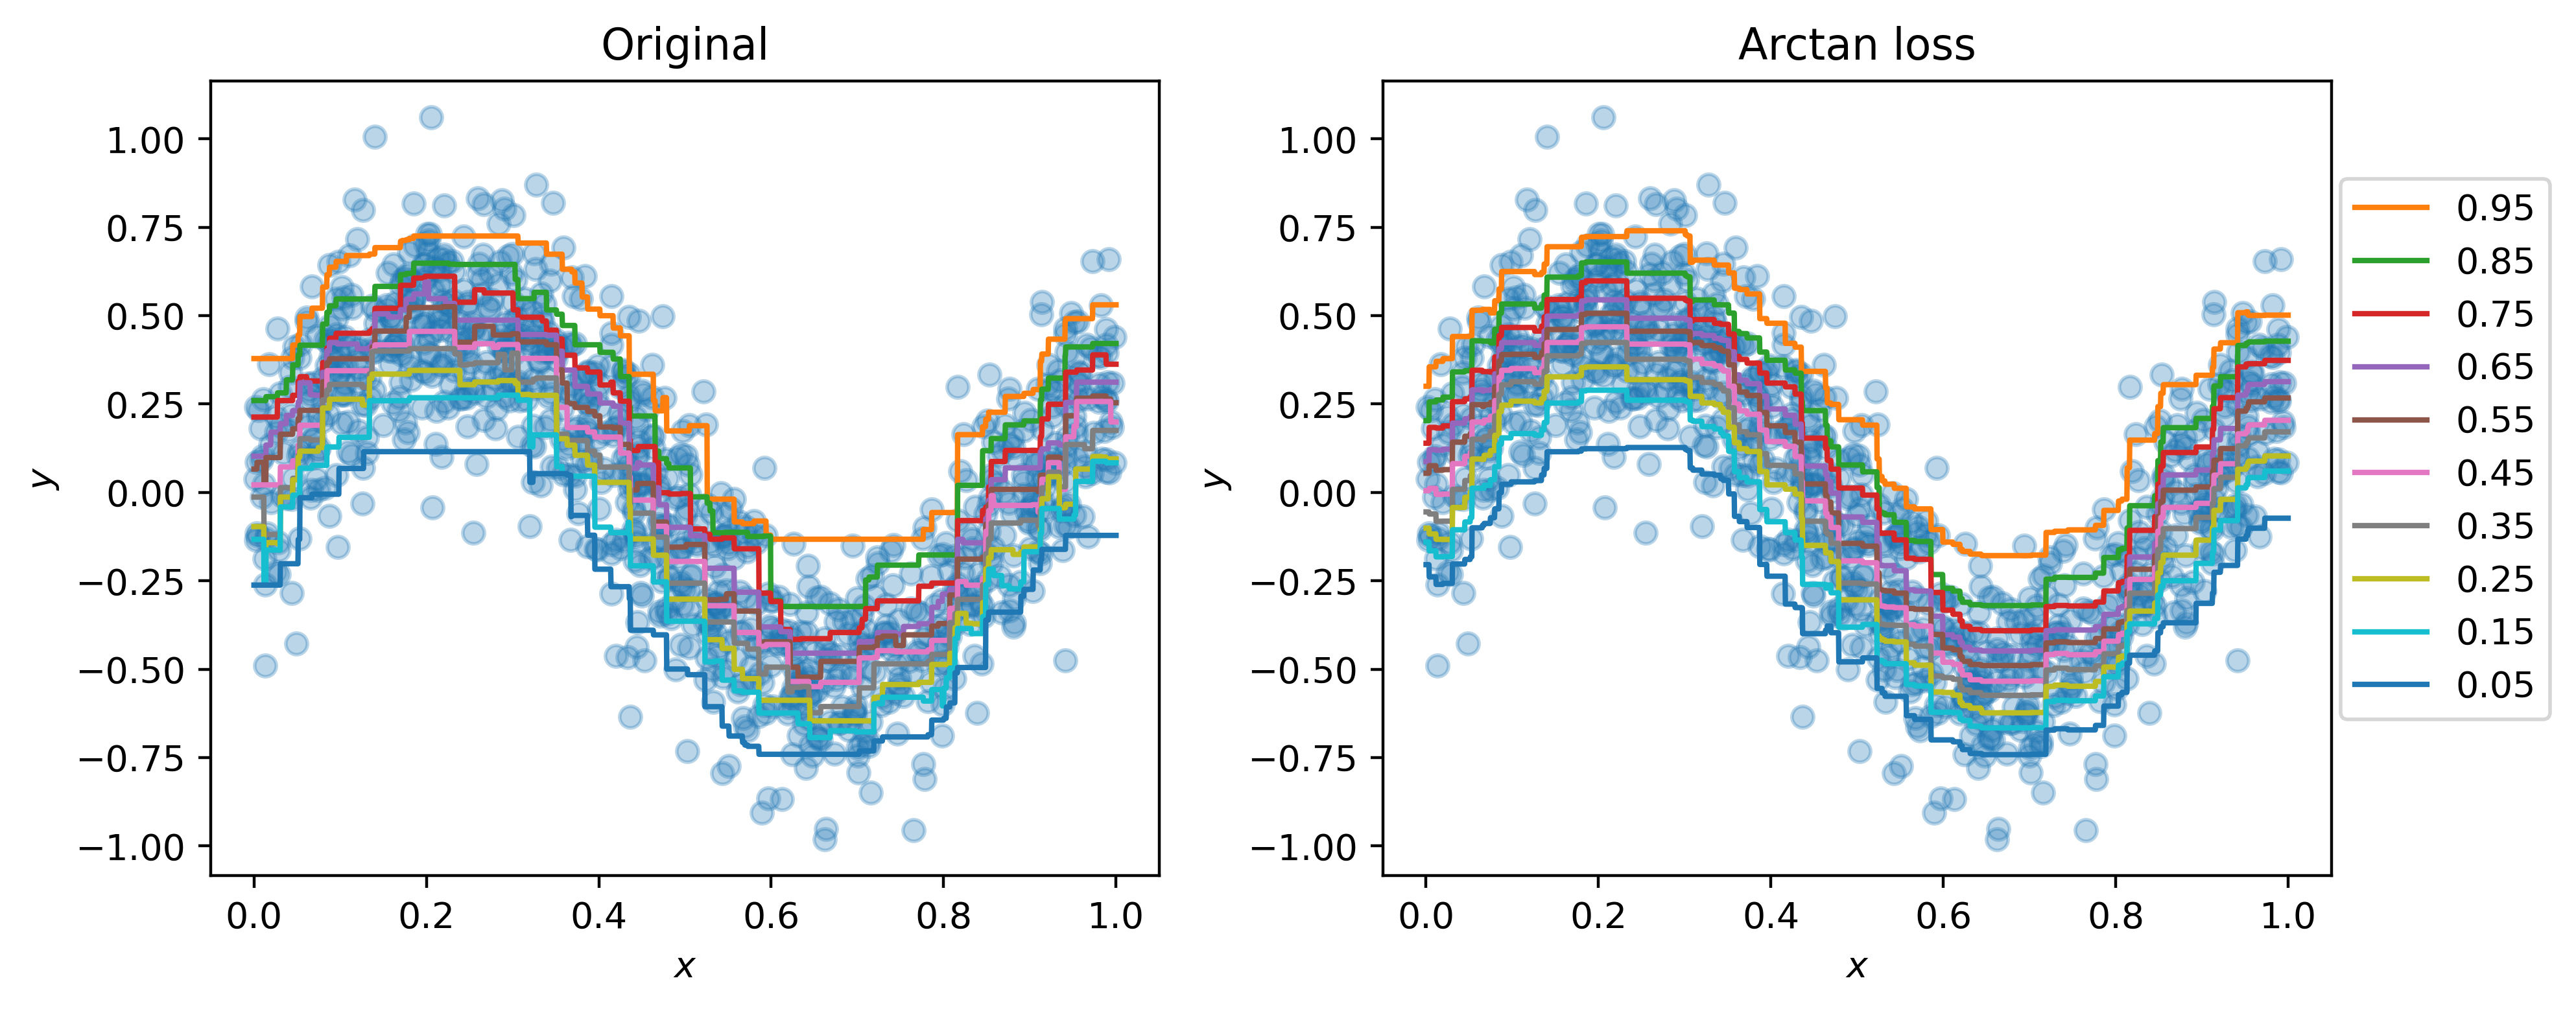

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=400)
ax1.set_title(r'Original')
ax1.plot(X, Y, 'o', alpha=0.3)
ax1.plot(x_values, original_quantiles)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax2.set_title(r'Arctan loss')
ax2.plot(X, Y, 'o', alpha=0.3)
ax2.plot(x_values, new_quantiles, label=taus)
ax2.legend(loc='upper right', bbox_to_anchor=(1.25, 0.9))
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')

plt.tight_layout()
plt.show()

### 2.3 Compare the crossing numbers

In [11]:
print(f'Crossings original approach: {compute_crossing_percentage(original_quantiles)}%')
print(f'Crossings new approach: {compute_crossing_percentage(new_quantiles)}%')
print(f'Old pinball_loss: {pinball_loss_total(original_quantiles, y_values[:, 0], taus) / len(y_values)}')
print(f'New pinball_loss: {pinball_loss_total(new_quantiles, y_values[:, 0], taus) / len(y_values)}')

Crossings original approach: 0.21481481481481482%
Crossings new approach: 0.0%
Old pinball_loss: 0.058853021202834734
New pinball_loss: 0.05865890126329066


### 2.4 Compare the coverages

In [12]:
for i in range(len(taus) // 2):
    tau = taus[i]
    print(f'{np.round((1-(1-tau)*2)*100,2)}% PI')
    quantiles = grid_search_new.best_estimator_.predict(X_test)
    uppercorrect = Y_test[:,0] < quantiles[:, i]
    lowercorrect = Y_test[:,0] > quantiles[:, -(i+1)]
    print(f'New coverage: {np.round(100*np.mean(uppercorrect*lowercorrect),2)}')
    quantiles = grid_search_original.best_estimator_.predict(X_test)
    uppercorrect = Y_test[:,0] < quantiles[:, i]
    lowercorrect = Y_test[:,0] > quantiles[:, -(i+1)]
    print(f'original coverage: {np.round(100*np.mean(uppercorrect*lowercorrect),2)}')
    print('------')

90.0% PI
New coverage: 85.89
original coverage: 85.81
------
70.0% PI
New coverage: 65.39
original coverage: 65.15
------
50.0% PI
New coverage: 46.71
original coverage: 45.78
------
30.0% PI
New coverage: 25.93
original coverage: 25.92
------
10.0% PI
New coverage: 8.39
original coverage: 8.13
------


In [13]:
grid_search_original.best_params_

{'regressor__gamma': 0.1,
 'regressor__lambda': 10,
 'regressor__learning_rate': 0.05,
 'regressor__max_depth': 2,
 'regressor__max_leaves': 400,
 'regressor__n_estimators': 400}

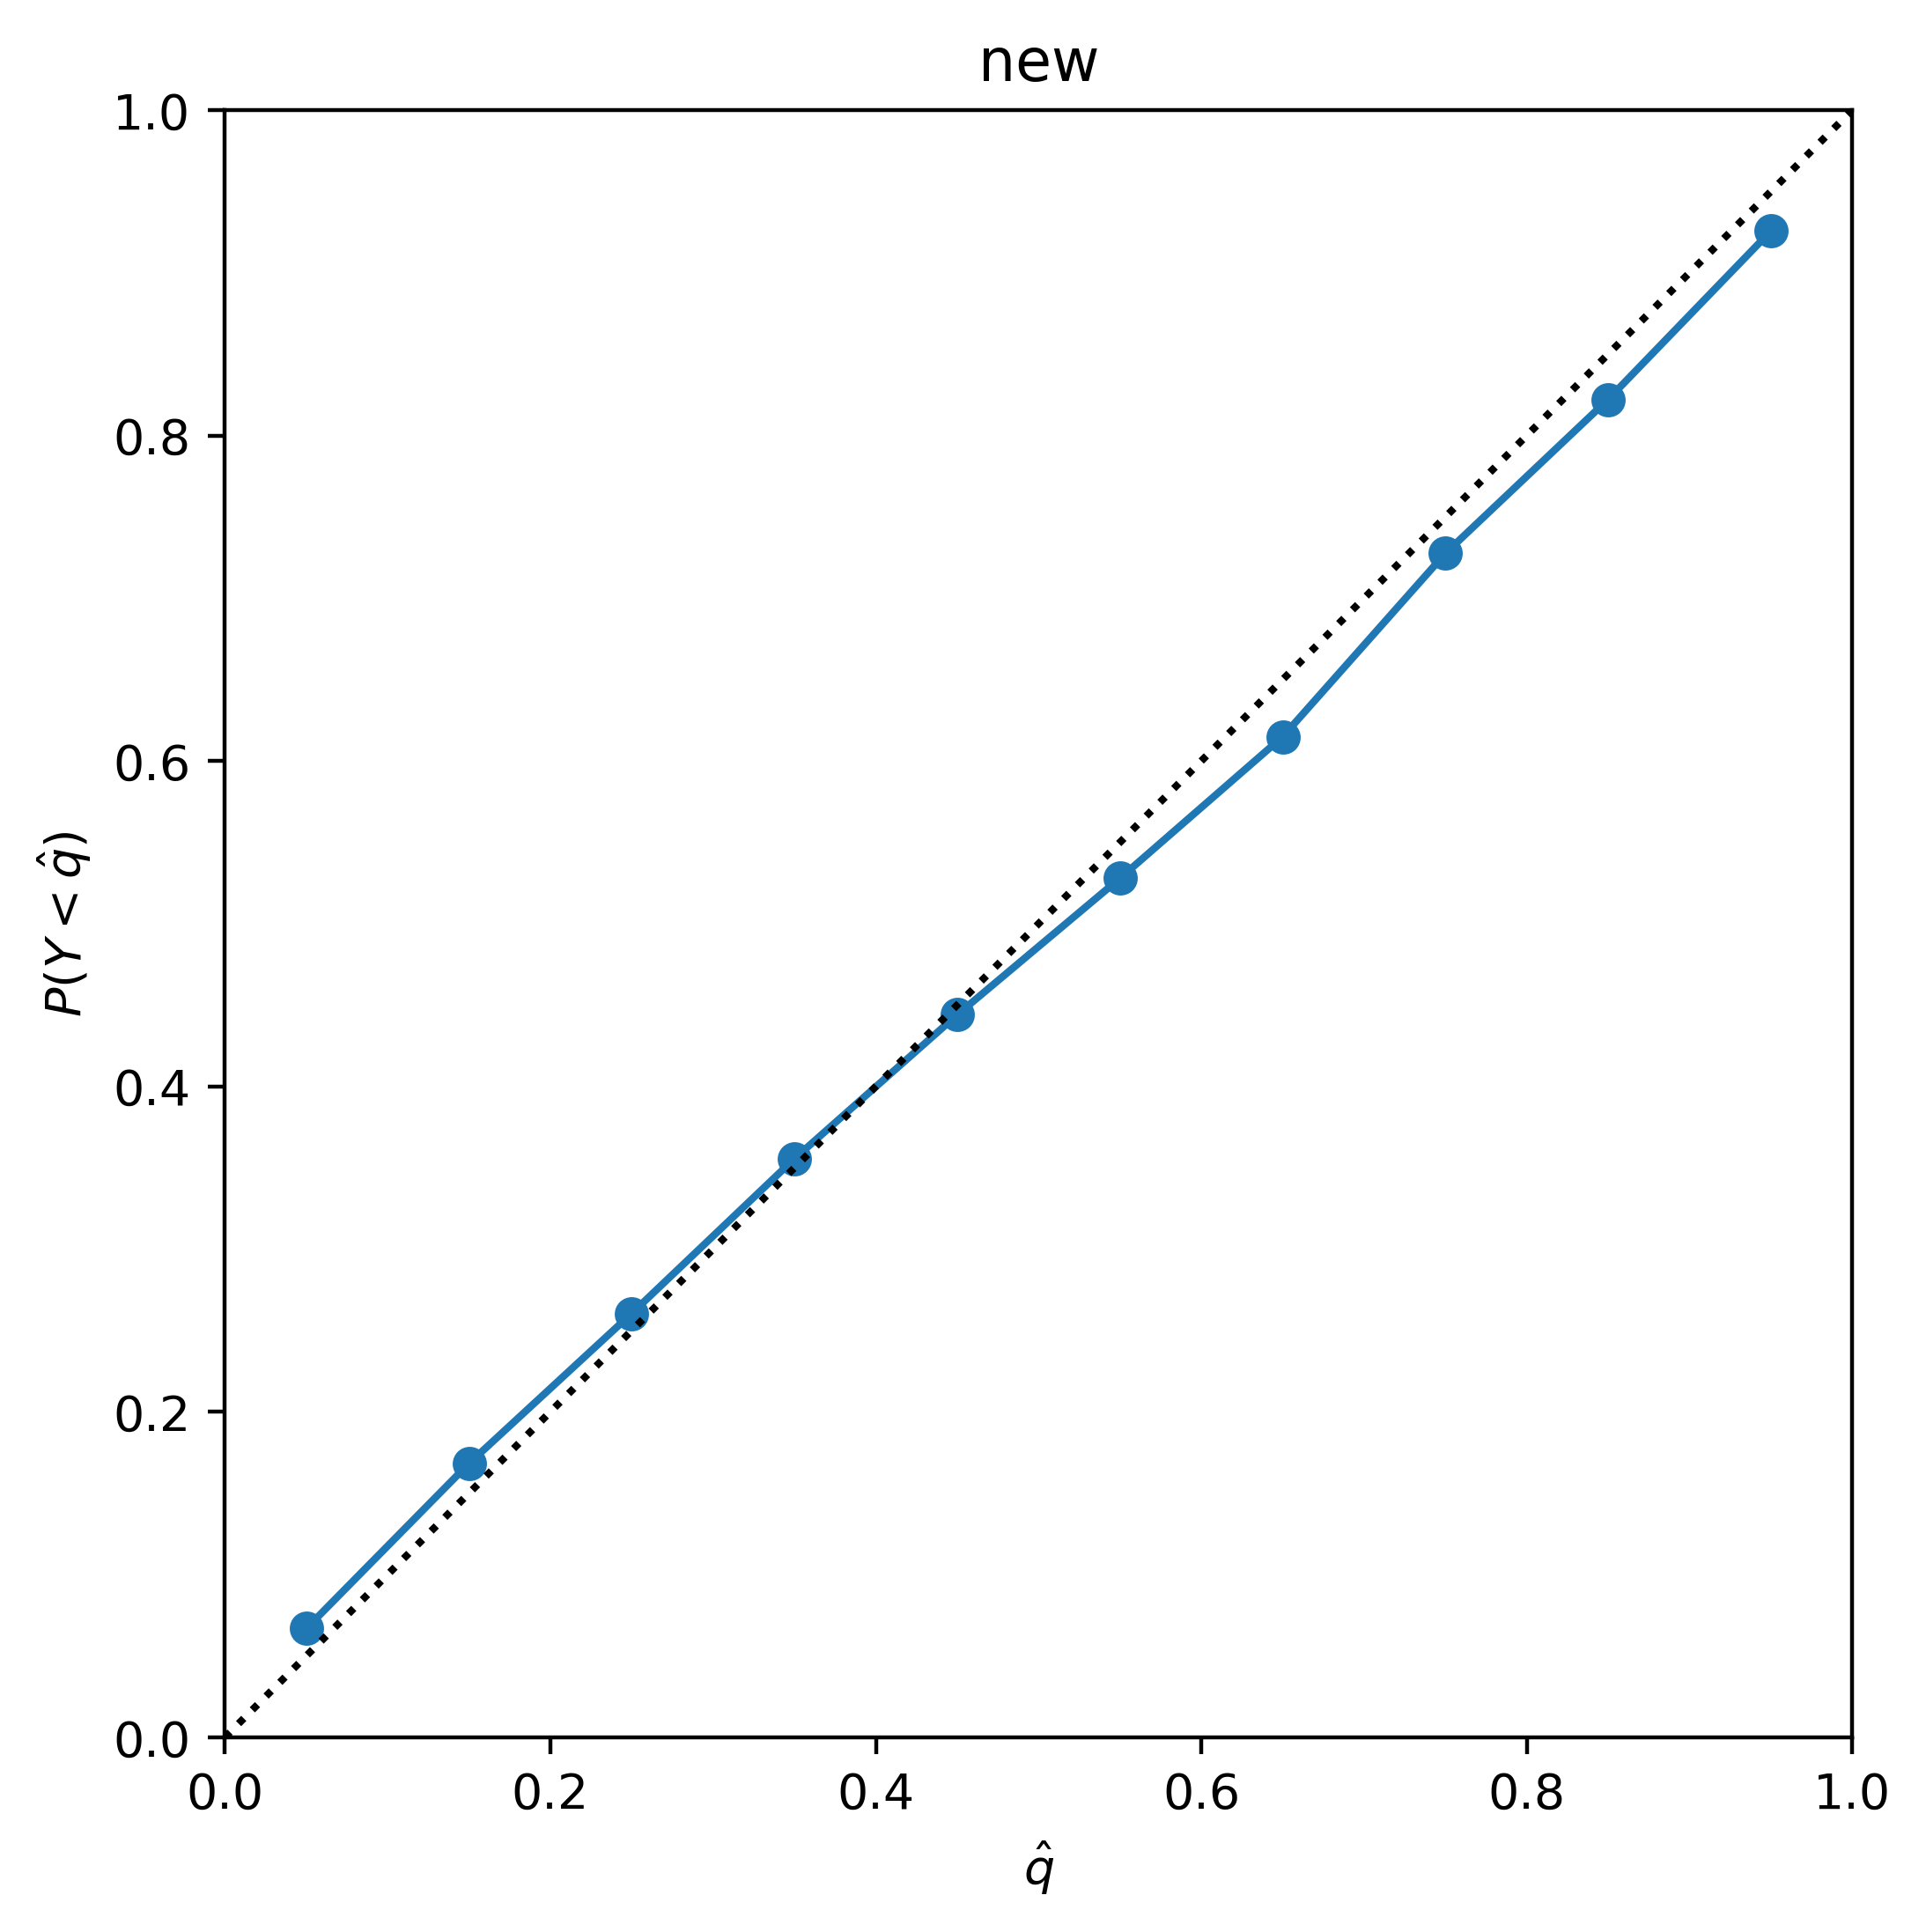

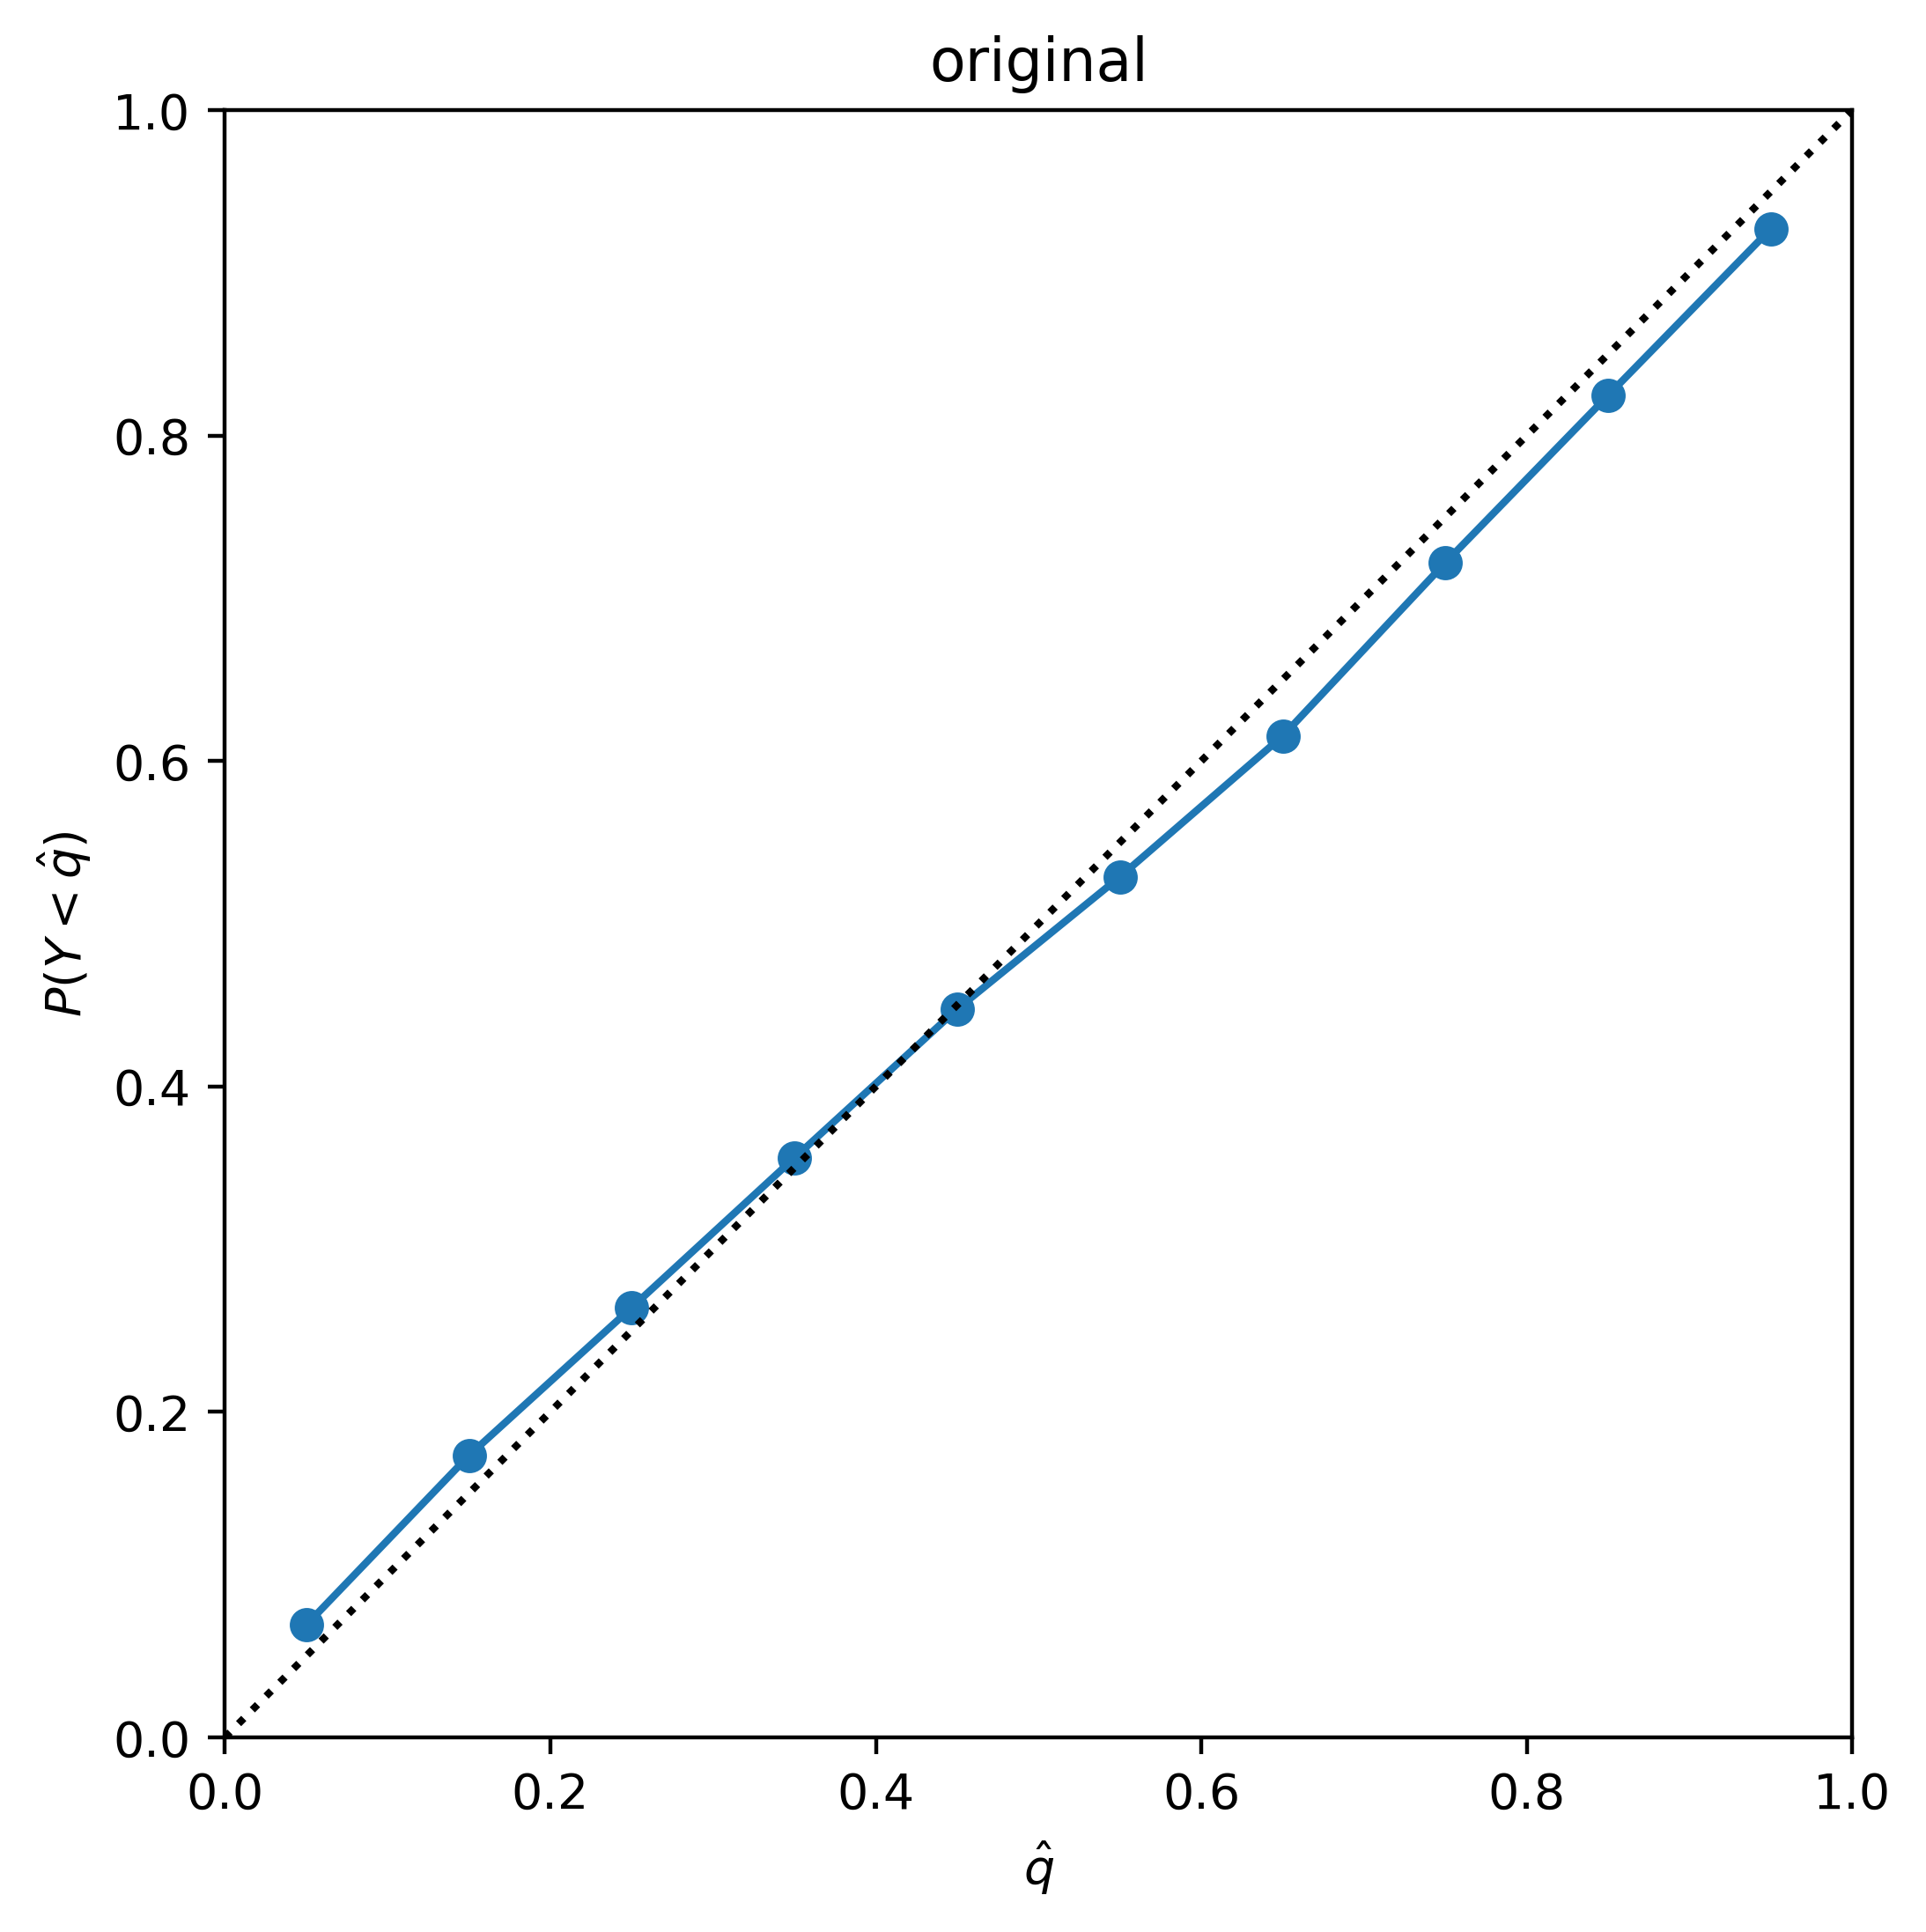

In [14]:
plot_quantiles(grid_search_new.best_estimator_.predict(X_test), Y_test[:, 0], taus=taus, title='new')
plot_quantiles(grid_search_original.best_estimator_.predict(X_test), Y_test[:, 0], taus=taus, title='original')